In [5]:
import glob
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

#通过创建data.Dataset子类Mydataset来创建输入
class Mydataset(data.Dataset):
# 类初始化
    def __init__(self, root):
        self.imgs_path = root
# 进行切片
    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        return img_path
# 返回长度
    def __len__(self):
        return len(self.imgs_path)



/home/lyc/doc/AML_LAB/img_data/False_3.png
/home/lyc/doc/AML_LAB/img_data/True_10.png
/home/lyc/doc/AML_LAB/img_data/True_3.png
/home/lyc/doc/AML_LAB/img_data/True_9.png
/home/lyc/doc/AML_LAB/img_data/False_6.png
/home/lyc/doc/AML_LAB/img_data/False_7.png
/home/lyc/doc/AML_LAB/img_data/True_5.png
/home/lyc/doc/AML_LAB/img_data/True_4.png
/home/lyc/doc/AML_LAB/img_data/False_1.png
/home/lyc/doc/AML_LAB/img_data/True_1.png
/home/lyc/doc/AML_LAB/img_data/False_4.png
/home/lyc/doc/AML_LAB/img_data/True_6.png
/home/lyc/doc/AML_LAB/img_data/False_10.png
/home/lyc/doc/AML_LAB/img_data/False_9.png
/home/lyc/doc/AML_LAB/img_data/True_7.png
/home/lyc/doc/AML_LAB/img_data/True_8.png
/home/lyc/doc/AML_LAB/img_data/False_8.png
/home/lyc/doc/AML_LAB/img_data/True_2.png
/home/lyc/doc/AML_LAB/img_data/False_5.png
/home/lyc/doc/AML_LAB/img_data/False_2.png
20
['/home/lyc/doc/AML_LAB/img_data/False_10.png', '/home/lyc/doc/AML_LAB/img_data/False_9.png', '/home/lyc/doc/AML_LAB/img_data/True_7.png']
['/hom

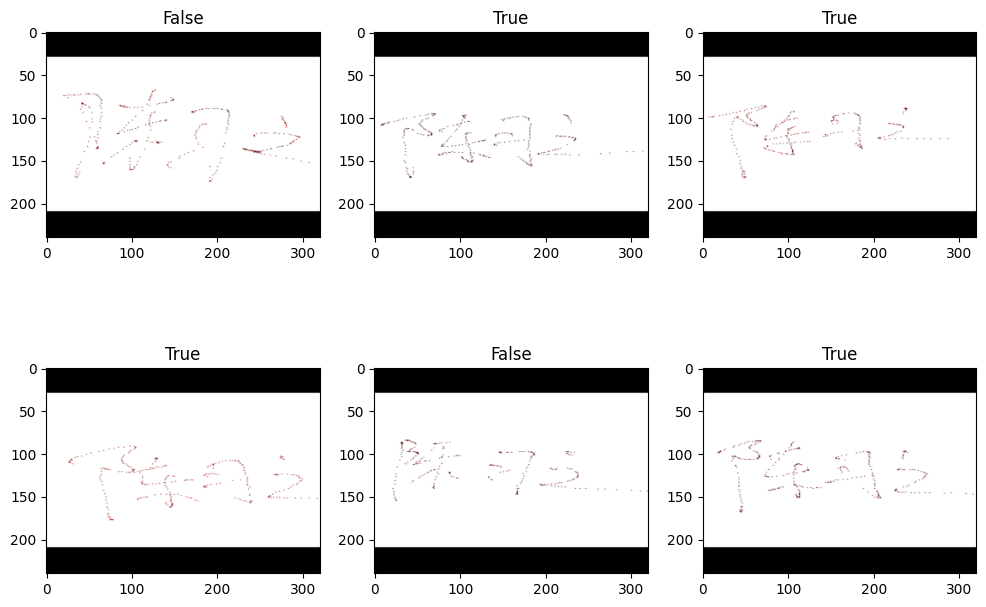

In [6]:
#使用glob方法来获取数据图片的所有路径
all_imgs_path = glob.glob(r'/home/lyc/doc/AML_LAB/img_data/*.png')#数据文件夹路径，根据实际情况更改！
#循环遍历输出列表中的每个元素，显示出每个图片的路径
for var in all_imgs_path:
    print(var)

#利用自定义类Mydataset创建对象weather_dataset
signature_dataset = Mydataset(all_imgs_path)
print(len(signature_dataset)) #返回文件夹中图片总个数
print(signature_dataset[12:15])#切片，显示第12至第十五张图片的路径
sinature_datalodaer = torch.utils.data.DataLoader(signature_dataset, batch_size=5) #每次迭代时返回五个数据
print(next(iter(sinature_datalodaer)))

species = ['False','True']
species_to_id = dict((c, i) for i, c in enumerate(species))
print(species_to_id)
id_to_species = dict((v, k) for k, v in species_to_id.items())
print(id_to_species)
all_labels = []
#对所有图片路径进行迭代
for img in all_imgs_path:
    # 区分出每个img，应该属于什么类别
    for i, c in enumerate(species):
        if c in img:
            all_labels.append(i)
#print(all_labels) #得到所有标签
            

            
# 对数据进行转换处理
transform = transforms.Compose([
                transforms.Resize((240,320)), #做的第一步转换
                transforms.ToTensor() #第二步转换，作用：第一转换成Tensor，第二将图片取值范围转换成0-1之间，第三会将channel置前
])

class Mydatasetpro(data.Dataset):
# 类初始化
    def __init__(self, img_paths, labels, transform):
        self.imgs = img_paths
        self.labels = labels
        self.transforms = transform
# 进行切片
    def __getitem__(self, index):                #根据给出的索引进行切片，并对其进行数据处理转换成Tensor，返回成Tensor
        img = self.imgs[index]
        label = self.labels[index]
        pil_img = Image.open(img)                 #pip install pillow
        data = self.transforms(pil_img)
        return data, label
# 返回长度
    def __len__(self):
        return len(self.imgs)



BATCH_SIZE = 10
signature_dataset = Mydatasetpro(all_imgs_path, all_labels, transform)
sinature_datalodaer = data.DataLoader(
                            signature_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True
)

imgs_batch, labels_batch = next(iter(sinature_datalodaer))
print(imgs_batch.shape)

plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs_batch[:6], labels_batch[:6])):
    img = img.permute(1, 2, 0).numpy()
    plt.subplot(2, 3, i+1)
    plt.title(id_to_species.get(label.item()))
    plt.imshow(img)
plt.show()#展示图片


In [7]:
import pandas as pd 

#划分测试集和训练集
index = np.random.permutation(len(all_imgs_path))

all_imgs_path = np.array(all_imgs_path)[index]
all_labels = np.array(all_labels)[index]

#80% as train
s = int(len(all_imgs_path)*0.7)
print(s)

train_imgs = all_imgs_path[:s]
train_labels = all_labels[:s]
test_imgs = all_imgs_path[s:]
test_labels = all_labels[s:]





print(test_labels)
train_ds = Mydatasetpro(train_imgs, train_labels, transform) #TrainSet TensorData
test_ds = Mydatasetpro(test_imgs, test_labels, transform) #TestSet TensorData

print(train_ds)
train_imgs = pd.get_dummies(train_imgs)
test_imgs = pd.get_dummies(test_imgs)
#print(train_ds)

train_dl = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)#TrainSet Labels
test_dl = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)#TestSet Labels






14
[0 1 0 0 0 1]


## 训练

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary
# 假设您的数据集已经准备好，包括训练集和验证集
# 这里仅作示例，您需要根据实际情况修改数据加载部分




# 初始化ResNet模型
model = resnet18(pretrained=True)
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 设置优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(30):  # 假设训练10个epoch
    model.train()
    running_loss = 0.0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/30], Loss: {running_loss / len(train_dl)}")



summary(model, input_size=(3,256,256), batch_size=-1, device='cuda')
# 验证模型


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Epoch [1/30], Loss: 0.4751560837030411
Epoch [2/30], Loss: 0.010391299845650792
Epoch [3/30], Loss: 0.010532168444115086
Epoch [4/30], Loss: 1.7238403728115372
Epoch [5/30], Loss: 0.47752003790810704
Epoch [6/30], Loss: 0.07404856383800507
Epoch [7/30], Loss: 1.697859323117882
Epoch [8/30], Loss: 0.3964265510439873
Epoch [9/30], Loss: 0.5429906863719225
Epoch [10/30], Loss: 0.06678271293640137
Epoch [11/30], Loss: 0.13394494354724884
Epoch [12/30], Loss: 0.10851030051708221
Epoch [13/30], Loss: 0.16172241233289242
Epoch [14/30], Loss: 0.03852596692740917
Epoch [15/30], Loss: 0.014345783274620771
Epoch [16/30], Loss: 0.004993361420929432
Epoch [17/30], Loss: 0.013193499995395541
Epoch [18/30], Loss: 0.0034307693131268024
Epoch [19/30], Loss: 0.00575858517549932
Epoch [20/30], Loss: 0.003077995963394642
Epoch [21/30], Loss: 0.0030920705758035183
Epoch [22/30], Loss: 0.0030566008063033223
Epoch [23/30], Loss: 0.002378901350311935
Epoch [24/30], Loss: 0.0008056814258452505
Epoch [25/30], L

In [9]:
print(predicted)

tensor([1, 0, 1, 1, 0, 0], device='cuda:0')
